In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/My Drive/cleaned_traindt.xlsx'
df = pd.read_excel(path)
df.head(10)

,AGREEMENTID,CUSTOMERID,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,CITY,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,FORECLOSURE,CUST_CONSTTYPE_ID,AGE,SEX,MARITAL_STATUS,QUALIFICATION,NO_OF_DEPENDENT,NETTAKEHOMEINCOME,PaidPrn-1,PaidPrn-2,PaidPrn-3,PaidPrn-4,PaidPrn-5,PaidPrn-6,PaidIntrst-1,PaidIntrst-2,PaidIntrst-3,PaidIntrst-4,PaidIntrst-5,PaidIntrst-6,EmiDue-1,EmiDue-2,EmiDue-3,EmiDue-4,EmiDue-5,EmiDue-6,DPD-1,DPD-2,DPD-3,DPD-4,DPD-5,DPD-6
0,11220001,12001000,11710107.24,2010-08-30,13.42,10.61,45,120,MUMBAI,7994.27,7994.27,0.0,8614898.28,8439420.50,175477.78,213586.86,213586.86,0.00,175477.78,116447.23,11593660.01,2725722.88,8693575.33,2014-05-05,1000000.0,40.06,45,0,0.0,0.60,HL,10901100,NaN,NaN,1,1.0,33.0,M,M,POSTGRAD,0.0,198375.22,9982394.87,9873401.90,9765376.67,9658310.58,9552640.58,9447930.42,2710245.45,2693791.64,2676370.10,2657989.42,2638212.64,2617476.02,184544.40,184544.40,0.00,184544.40,184544.40,184544.40,0.0,0.0,0.0,0.0,0.0,0.0
1,11220002,12001001,19290253.32,2010-09-15,13.73,10.61,137,180,MUMBAI,100504.58,100504.58,0.0,10619027.21,10339579.13,279448.08,0.00,0.00,0.00,279448.08,12347597.30,6942656.03,4945153.59,17138606.02,2013-11-01,126530.0,84.31,38,99,0.0,0.60,HL,10901100,NaN,NaN,1,1.0,44.0,M,M,POSTGRAD,0.0,242703.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11220006,12001005,3933395.00,2010-11-01,15.61,11.55,312,180,MUMBAI,5947.63,5947.63,0.0,4670210.68,4670210.68,0.00,1179715.72,1179715.72,0.00,0.00,2994183.52,939211.48,2990124.01,3744831.42,2017-08-05,22878.0,50.89,81,231,0.0,0.72,HL,10901101,NaN,NaN,1,3.0,43.0,M,M,GRAD,0.0,53536.21,936086.79,932994.31,929933.73,926904.68,924444.55,922093.00,2958902.06,2927647.89,2896361.83,2865044.23,2833157.71,2801162.62,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,11220008,12001007,10022587.71,2010-10-06,11.24,10.61,91,180,THANE,60322.18,60322.18,0.0,13130976.81,13067317.53,63659.28,6770848.42,6770848.42,0.00,63659.28,42951.20,9979636.50,4648994.27,5747875.24,2018-05-02,65741.0,84.63,91,0,0.0,0.60,HL,10901100,NaN,NaN,1,1.0,33.0,M,M,POSTGRAD,0.0,123370.48,9881994.27,9785078.90,9688884.98,9593407.14,9498640.07,9404578.45,4647939.82,4646158.51,4643655.74,4640436.89,4636507.28,4631872.21,145192.42,145192.42,145192.42,145192.42,145192.42,145192.42,0.0,0.0,0.0,0.0,0.0,0.0
4,11220010,12001009,7755937.31,2010-10-26,14.98,10.92,304,180,MUMBAI,27732.79,27732.79,0.0,10489232.82,10489232.82,0.00,120218.11,120218.11,0.00,0.00,7200652.61,555284.70,6593777.81,7200652.61,2018-04-05,54433.0,30.94,89,215,0.0,0.83,HL,10901101,NaN,NaN,1,3.0,37.0,M,M,UG,0.0,93803.84,545667.34,536145.20,526717.35,517382.83,508140.74,498990.16,6521675.14,6449477.23,6377185.05,6304799.54,6232321.60,6159752.14,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,11220011,12001010,954408.27,2010-10-28,12.42,10.61,235,180,THANE,1325.13,1325.13,0.0,1355118.92,1341291.17,13827.74,27655.49,27655.49,0.00,13827.74,769138.61,185269.66,727393.58,769138.61,2018-12-07,6261.0,23.24,98,137,0.0,0.60,HL,10901100,NaN,NaN,0,1.0,30.0,M,M,GRAD,0.0,35880.97,182272.34,179299.67,175868.86,172464.15,169085.35,165601.78,720991.29,714564.35,708595.54,702600.64,696579.83,690663.78,13827.74,13827.74,13827.74,13827.74,13827.74,13827.74,0.0,0.0,0.0,0.0,0.0,0.0
6,11220012,12001011,6605701.52,2010-11-19,16.17,10.92,390,300,MUMBAI,37790.53,37790.53,0.0,9101193.23,8910126.97,191066.25,95533.13,95533.13,0.00,191066.25,5765533.27,840168.25,5692699.41,6215922.01,2018-12-11,43256.0,60.69,96,294,56.0,0.55,HL,10901100,NaN,NaN,0,1.0,33.0,M,M,GRAD,0.0,63576.87,834384.19,828182.25,828182.25,828182.25,822042.71,815136.98

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19731 entries, 0 to 19730
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AGREEMENTID            19731 non-null  int64         
 1   CUSTOMERID             19731 non-null  int64         
 2   NET_DISBURSED_AMT      19731 non-null  float64       
 3   INTEREST_START_DATE    19731 non-null  datetime64[ns]
 4   CURRENT_ROI            19731 non-null  float64       
 5   ORIGNAL_ROI            19731 non-null  float64       
 6   CURRENT_TENOR          19731 non-null  int64         
 7   ORIGNAL_TENOR          19731 non-null  int64         
 8   CITY                   19731 non-null  object        
 9   PRE_EMI_DUEAMT         19731 non-null  float64       
 10  PRE_EMI_RECEIVED_AMT   19731 non-null  float64       
 11  PRE_EMI_OS_AMOUNT      19731 non-null  float64       
 12  EMI_DUEAMT             19731 non-null  float64       
 13  E

Text(0.5, 1.0, 'No. of foreclosure and non-foreclosure cases')

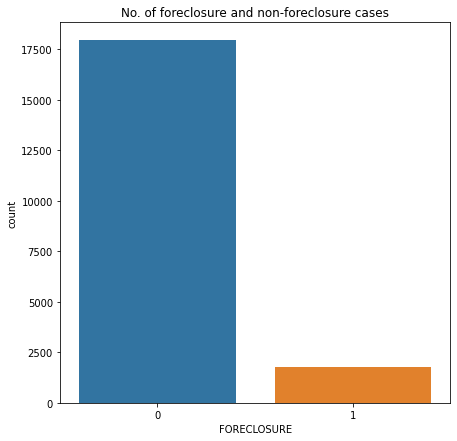

In [ ]:
# Distribution of Tartget variable
plt.figure(figsize=(7,7))
sns.countplot(x="FORECLOSURE", data=df)
plt.title('No. of foreclosure and non-foreclosure cases')

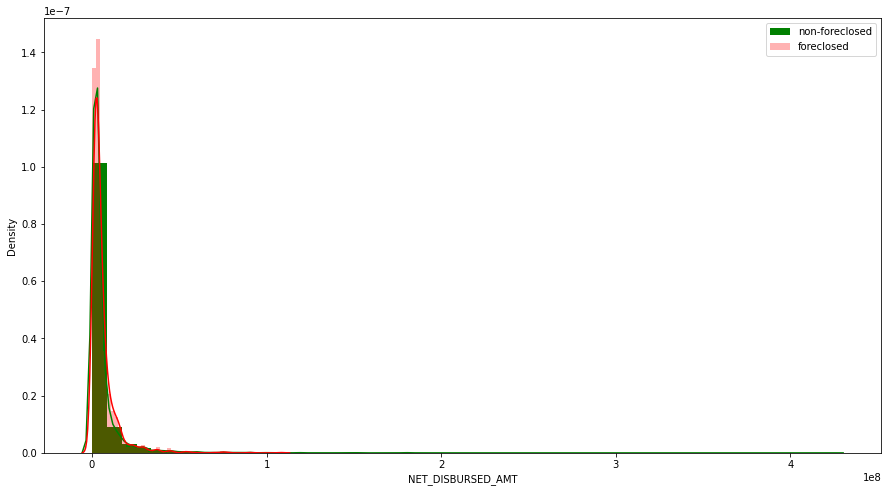

In [ ]:
foreclose_amt = df.loc[df.FORECLOSURE == 1]["NET_DISBURSED_AMT"]
non_foreclose_amt = df.loc[df.FORECLOSURE == 0]["NET_DISBURSED_AMT"]

plt.figure(figsize=(15,8))
sns.distplot(non_foreclose_amt,label='non-foreclosed',color='green',hist_kws=dict(alpha=1))
sns.distplot(foreclose_amt,label='foreclosed',color='red',hist_kws=dict(alpha=0.3))
plt.legend(loc='upper right')
plt.show()

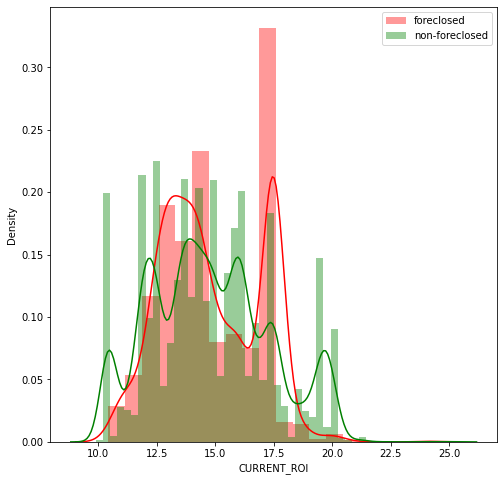

In [ ]:
foreclose_roi = df.loc[df.FORECLOSURE == 1]["CURRENT_ROI"]
non_foreclose_roi = df.loc[df.FORECLOSURE == 0]["CURRENT_ROI"]

plt.figure(figsize=(8,8))
sns.distplot(foreclose_roi,label='foreclosed',color='red')
sns.distplot(non_foreclose_roi,label='non-foreclosed',color='green')
plt.legend(loc='upper right')
plt.show()

The rate of interest for both foreclosed and non foreclosed loans seem to overlap mostly.

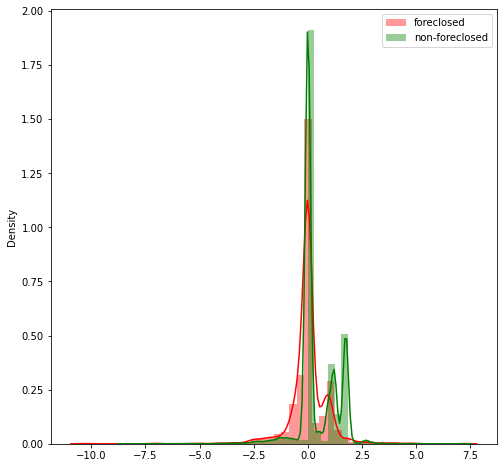

In [4]:
df_roi = df[df['FORECLOSURE']==0][['ORIGNAL_ROI','CURRENT_ROI']]
diff = df_roi.CURRENT_ROI - df_roi.ORIGNAL_ROI

foreclosure_roi = df[df['FORECLOSURE']==1][['ORIGNAL_ROI','CURRENT_ROI']]
diff1 = foreclosure_roi.CURRENT_ROI - foreclosure_roi.ORIGNAL_ROI

plt.figure(figsize=(8,8))
sns.distplot(diff1,label='foreclosed',color='red')
sns.distplot(diff,label='non-foreclosed',color='green')
plt.legend(loc='upper right')
plt.show()

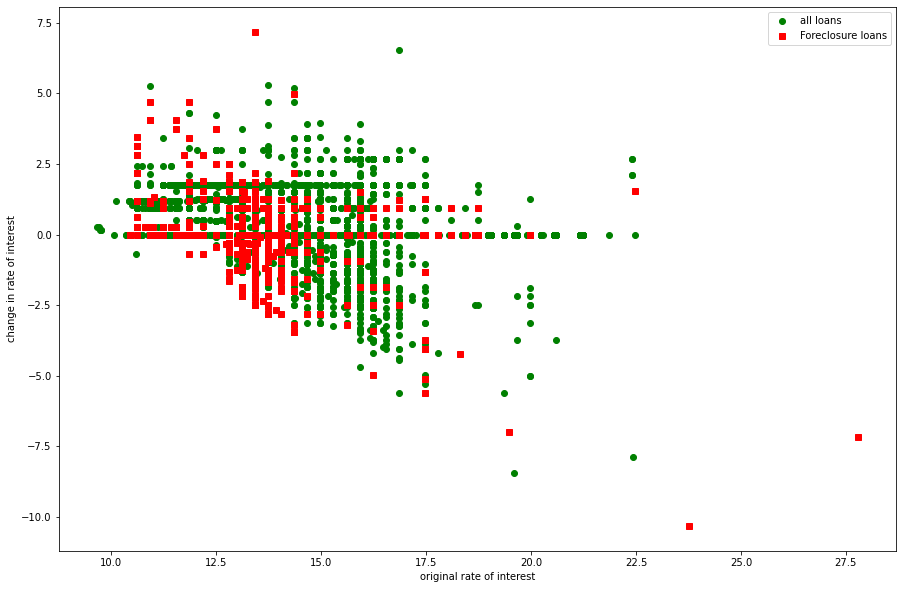

In [ ]:
# interaction of original ROI and current ROI
df_roi = df[['ORIGNAL_ROI','CURRENT_ROI']]
diff = df_roi.CURRENT_ROI - df_roi.ORIGNAL_ROI

foreclosure_roi = df[df['FORECLOSURE']==1][['ORIGNAL_ROI','CURRENT_ROI']]
org_roi = foreclosure_roi.ORIGNAL_ROI
diff1 = foreclosure_roi.CURRENT_ROI - foreclosure_roi.ORIGNAL_ROI

plt.figure(figsize=(15,10))
plt.plot(df_roi.ORIGNAL_ROI,diff,color='green',marker='o',linestyle='None',label='all loans')
plt.plot(org_roi,diff1,color='red',marker='s',linestyle='None',label='Foreclosure loans')
plt.xlabel('original rate of interest')
plt.ylabel('change in rate of interest')
plt.legend()


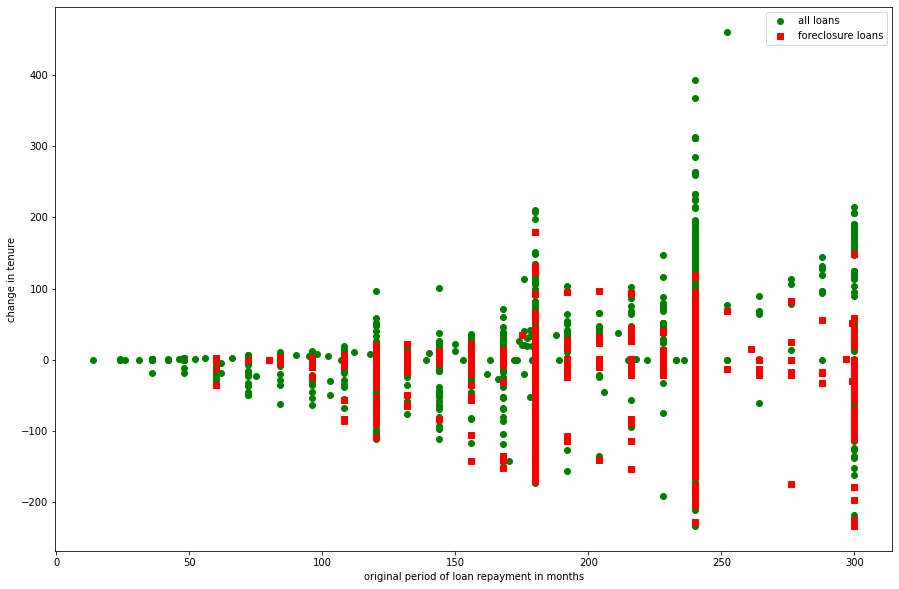

In [ ]:
# interaction of original tenure of loan repayement to current tenure
df_dur = df[['ORIGNAL_TENOR','CURRENT_TENOR']]
diff = df_dur.CURRENT_TENOR - df_dur.ORIGNAL_TENOR

foreclosure_dur = df[df['FORECLOSURE']==1][['ORIGNAL_TENOR','CURRENT_TENOR']]
org_dur = foreclosure_dur.ORIGNAL_TENOR
diff1 = foreclosure_dur.CURRENT_TENOR - foreclosure_dur.ORIGNAL_TENOR

plt.figure(figsize=(15,10))
plt.plot(df_dur.ORIGNAL_TENOR,diff,color='green',marker='o',linestyle='None',label='all loans')
plt.plot(org_dur,diff1,color='red',marker='s',linestyle='None',label='foreclosure loans')
plt.xlabel('original period of loan repayment in months')
plt.ylabel('change in tenure')
plt.legend()

In [ ]:
# Number of cities from where loans were applied
print(df.CITY.nunique())

270


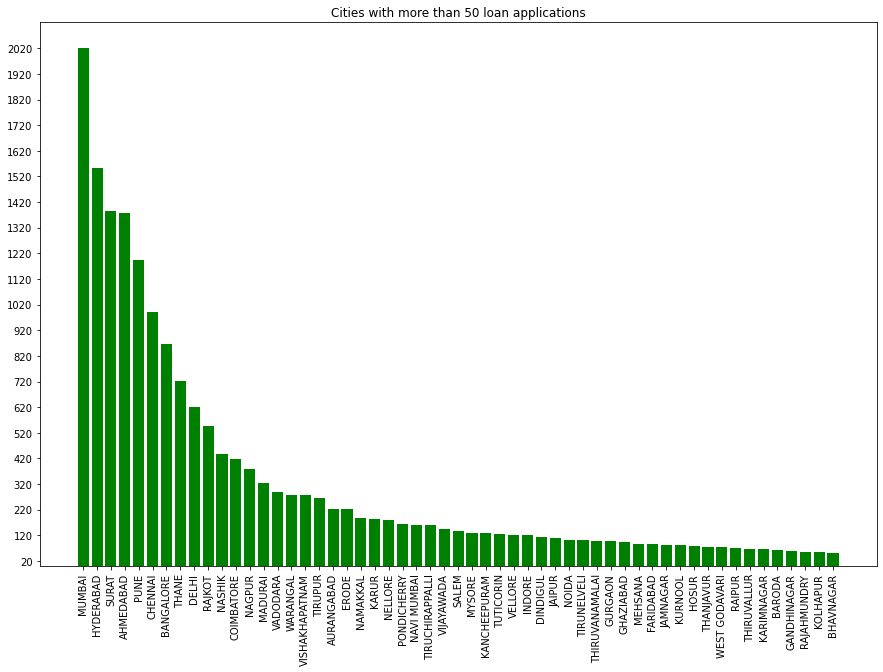

In [ ]:
# Number of loans from various cities
city_count = df.CITY.value_counts()
# Cities where the no. of loan application is more than 50
city50 = city_count[city_count.values > 50]
plt.figure(figsize=(15,10))
height = city50.values
bars = city50.index
y_pos = np.arange(len(bars)) 
# Creating bars
plt.title('Cities with more than 50 loan applications')
plt.bar(y_pos, height,color='green') 
# Creating names on the x-axis
plt.yticks(np.arange(20,2050,100))
plt.xticks(y_pos, bars,rotation=90)
plt.show()

In [ ]:
total_count = df.groupby(['CITY']).agg({'FORECLOSURE': ['count']})
total_count.columns = ['count']
total_count = total_count.reset_index()
total_count

,CITY,count
0,24 PARGANAS,2
1,ADILABAD,3
2,AHMEDABAD,1378
3,AHMEDNAGAR,20
4,ALAPPUZHA,1
...,...,...
265,WARANGAL,276
266,WEST GODAVARI,75
267,YANAM,3
268,YAVATMAL,1


In [ ]:
df1 = df[df.FORECLOSURE == 1][['CITY','FORECLOSURE']]
group = df1.groupby(['CITY']).agg({'FORECLOSURE': ['count']})
group.columns = ['count']
group = group.reset_index()
group

,CITY,count
0,AHMEDABAD,90
1,ARAKKONAM,3
2,BANGALORE,81
3,BARODA,10
4,CHENGALPATTU,1
...,...,...
79,VILLUPURAM,3
80,VISHAKHAPATNAM,19
81,VIZIANAGARAM,1
82,WARANGAL,15


In [ ]:
s1 = total_count.loc[total_count.CITY.isin(group.CITY)]
foreclose_count = s1['count']
foreclose_count.reset_index(drop=True,inplace=True)

In [ ]:
perc = group['count'] / foreclose_count
perc = perc * 100
group['perc'] = perc 

In [ ]:
group.sort_values('perc',ascending=False,inplace=True)
group.reset_index(drop=True,inplace=True)

In [ ]:
# c = df.groupby('FORECLOSURE')
# c = c.get_group(1)
# foreclosure_city=pd.Series(list(c.CITY))
# foreclosure_city_count = foreclosure_city.value_counts()

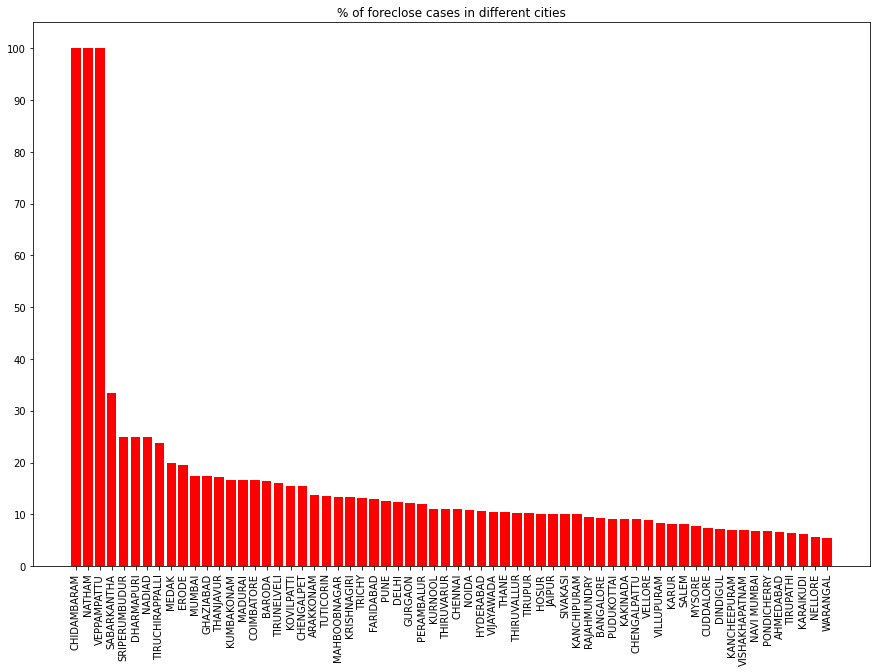

In [ ]:
fcity = group[group['perc']>5]
plt.figure(figsize=(15,10))
height = fcity['perc']
bars = fcity['CITY']
y_pos = np.arange(len(bars)) 
# Creating bars
plt.title('% of foreclose cases in different cities')
plt.bar(y_pos, height,color='red') 
# Creating names on the x-axis
plt.yticks(np.arange(0,110,10))
plt.xticks(y_pos, bars,rotation=90)
plt.show()

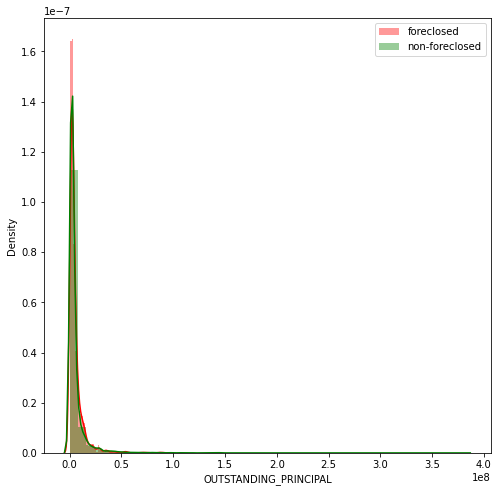

In [ ]:
# OUTSTANDING_PRINCIPAL
foreclose_outstanding = df.loc[df.FORECLOSURE == 1]["OUTSTANDING_PRINCIPAL"]
non_foreclose_outstanding = df.loc[df.FORECLOSURE == 0]["OUTSTANDING_PRINCIPAL"]

plt.figure(figsize=(8,8))
sns.distplot(foreclose_outstanding,label='foreclosed',color='red')
sns.distplot(non_foreclose_outstanding,label='non-foreclosed',color='green')
plt.legend(loc='upper right')
plt.show()

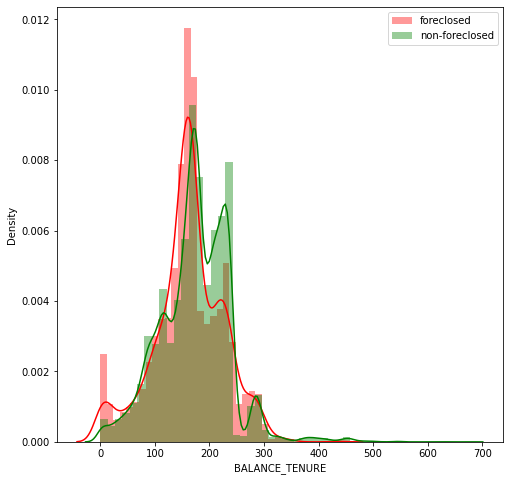

In [ ]:
# Balance Tenure
foreclose_tenure = df.loc[df.FORECLOSURE == 1]["BALANCE_TENURE"]
non_foreclose_tenure = df.loc[df.FORECLOSURE == 0]["BALANCE_TENURE"]

plt.figure(figsize=(8,8))
sns.distplot(foreclose_tenure,label='foreclosed',color='red')
sns.distplot(non_foreclose_tenure,label='non-foreclosed',color='green')
plt.legend(loc='upper right')
plt.show()

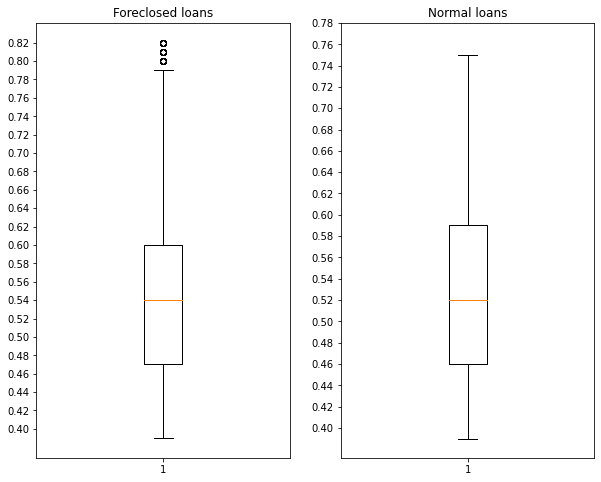

In [ ]:
# FOIR (Fixed Obligation to income ratio)
foreclose_foir = df.loc[df.FORECLOSURE == 1]["FOIR"]
non_foreclose_foir = df.loc[df.FORECLOSURE == 0]["FOIR"]

foreclose_foir = foreclose_foir[foreclose_foir.between(foreclose_foir.quantile(.20), foreclose_foir.quantile(.80))] # removing outliers
non_foreclose_foir = non_foreclose_foir[non_foreclose_foir.between(non_foreclose_foir.quantile(.20), non_foreclose_foir.quantile(.80))] # removing outliers

plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.boxplot(foreclose_foir)
plt.yticks(np.arange(0.4,0.84,0.02))
plt.title('Foreclosed loans')

plt.subplot(1, 2, 2)
plt.boxplot(non_foreclose_foir)
plt.yticks(np.arange(0.4,0.8,0.02))
plt.title('Normal loans')
plt.show()

FOIR - Fixed Obligation to income ratio is calculated to assess how much of the income would go into paying the installments. A higer FOIR is a bad sign. On close inspection of the two box plots it seems that normal loans have a lower FOIR than Foreclosed loans.

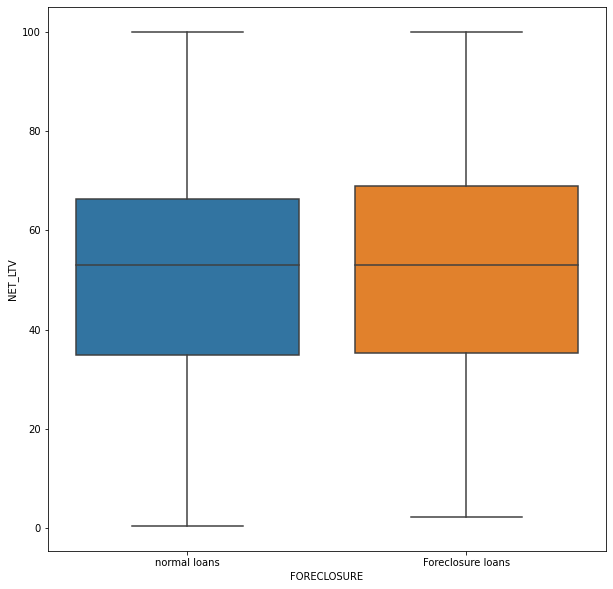

In [ ]:
# NET loan to volume ratio
plt.figure(figsize=(10,10))
sns.boxplot(x='FORECLOSURE',y='NET_LTV',data=df)
x_values = [0,1]
x_names = ['normal loans','Foreclosure loans']
plt.xticks(x_values,x_names)
plt.show()

The Boxplot for the normal loans seems to be left skewed and the foreclosed one seems fairly symmetric. This means the mean Net-to-loan ratio is lower in case of normal loans than in Foreclosed ones. Higher NTL ratio indicates inability to repay loans.

In [ ]:
df.SCHEMEID.nunique()

235

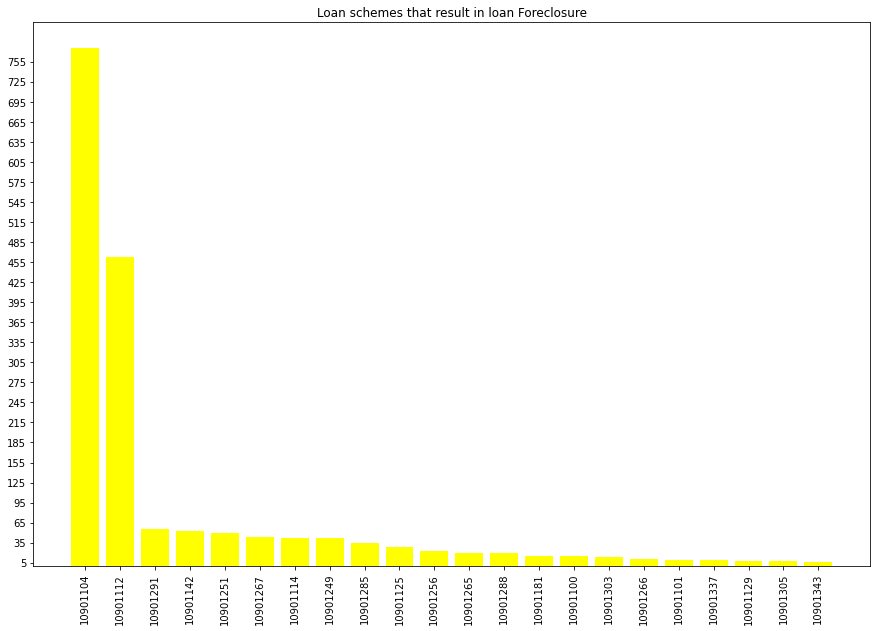

In [ ]:
bad_schemes = df[df['FORECLOSURE']==1][['SCHEMEID','FORECLOSURE']]
badschemecount = bad_schemes.SCHEMEID.value_counts()
badscheme5 = badschemecount[badschemecount.values > 5]
plt.figure(figsize=(15,10))
height = badscheme5.values
bars = badscheme5.index
y_pos = np.arange(len(bars)) 
# Creating bars
plt.title('Loan schemes that result in loan Foreclosure')
plt.bar(y_pos, height,color='yellow') 
# setting the y
plt.yticks(np.arange(5,780,30))
# Creating names on the x-axis
plt.xticks(y_pos, bars,rotation=90)
plt.show()

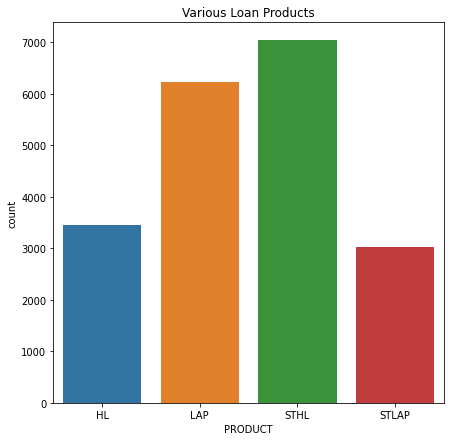

In [ ]:
# Count of different types of loans
plt.figure(figsize=(7,7))
sns.countplot(x="PRODUCT", data=df)
plt.title('Various Loan Products')
plt.show()

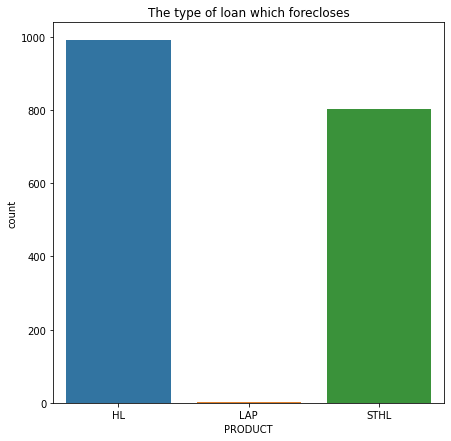

In [ ]:
foreclosure_product = df[df['FORECLOSURE']==1][['PRODUCT','FORECLOSURE']]
plt.figure(figsize=(7,7))
sns.countplot(x="PRODUCT", data=foreclosure_product)
plt.title('The type of loan which forecloses')
plt.show()

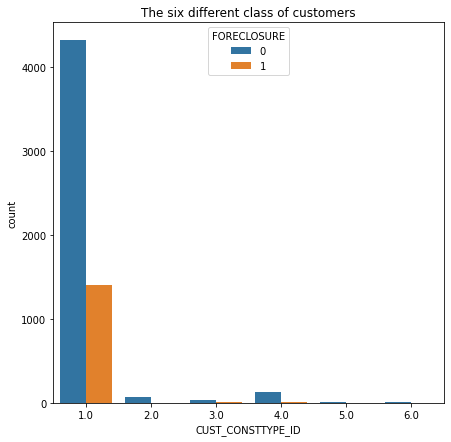

In [ ]:
# CUST_CONSTTYPE_ID
plt.figure(figsize=(7,7))
sns.countplot(x='CUST_CONSTTYPE_ID',data=df,hue='FORECLOSURE')
plt.title('The six different class of customers')
plt.show()

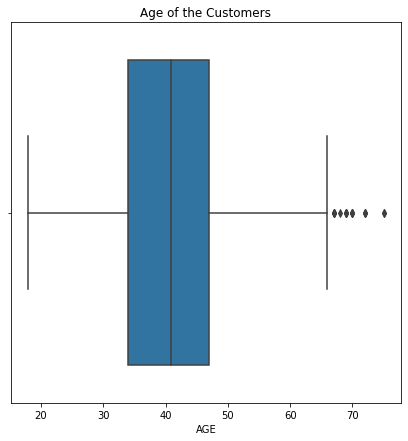

In [ ]:
# distribution of age of the customers
plt.figure(figsize=(7,7))
sns.boxplot(x='AGE',data=df)
plt.title('Age of the Customers')
plt.show()

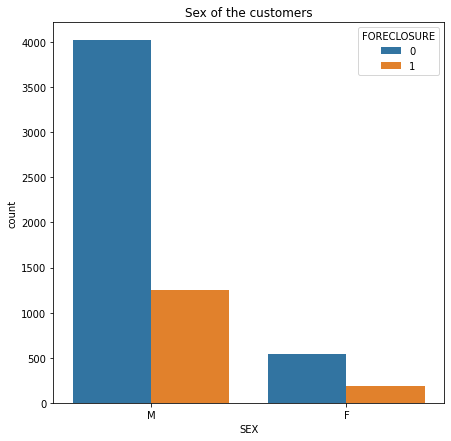

In [ ]:
# Sex of customer
plt.figure(figsize=(7,7))
sns.countplot(x='SEX',data=df,hue='FORECLOSURE')
plt.title('Sex of the customers')
plt.show()

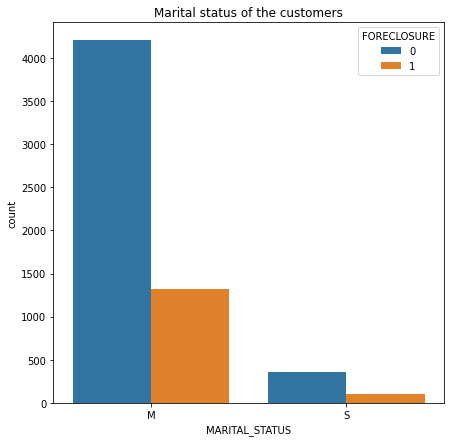

In [ ]:
# marital status
plt.figure(figsize=(7,7))
sns.countplot(x='MARITAL_STATUS',data=df,hue='FORECLOSURE')
plt.title('Marital status of the customers')
plt.show()

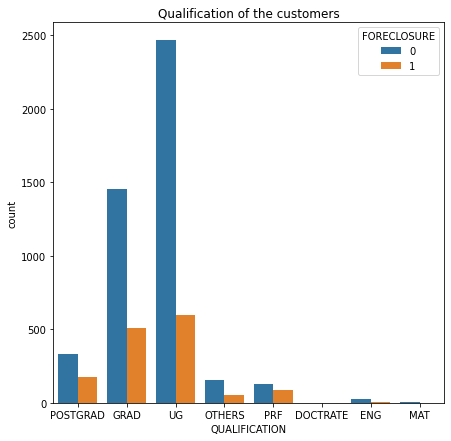

In [ ]:
# qualification
plt.figure(figsize=(7,7))
sns.countplot(x='QUALIFICATION',data=df,hue='FORECLOSURE')
plt.title('Qualification of the customers')
plt.show()

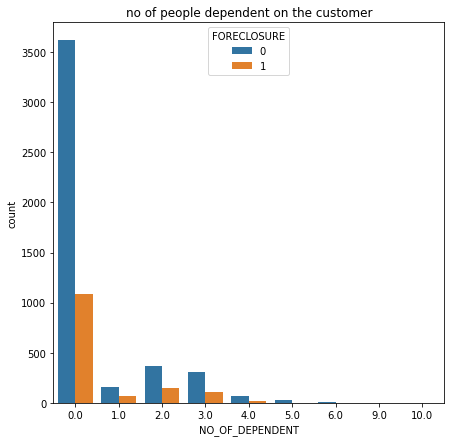

In [ ]:
# no of people dependent on the customer
plt.figure(figsize=(7,7))
sns.countplot(x='NO_OF_DEPENDENT',data=df,hue='FORECLOSURE')
plt.title('no of people dependent on the customer')
plt.show()

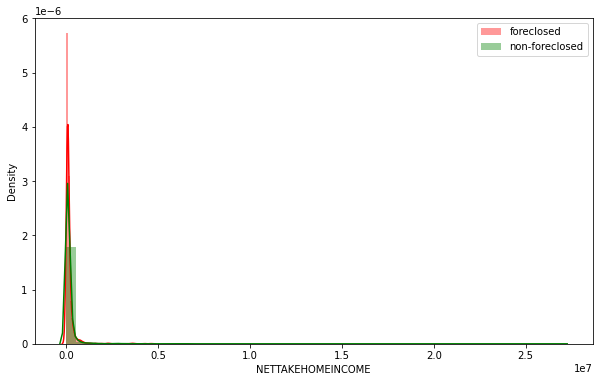

In [ ]:
 # Net Take home income

foreclose_income = df.loc[df.FORECLOSURE == 1]["NETTAKEHOMEINCOME"]
non_foreclose_income = df.loc[df.FORECLOSURE == 0]["NETTAKEHOMEINCOME"]

# foreclose_income.dropna(inplace=True)
# non_foreclose_income.dropna(inplace=True)

plt.figure(figsize=(10,6))
sns.distplot(foreclose_income,label='foreclosed',color='red')
sns.distplot(non_foreclose_income,label='non-foreclosed',color='green')

plt.legend(loc='upper right')

plt.show()

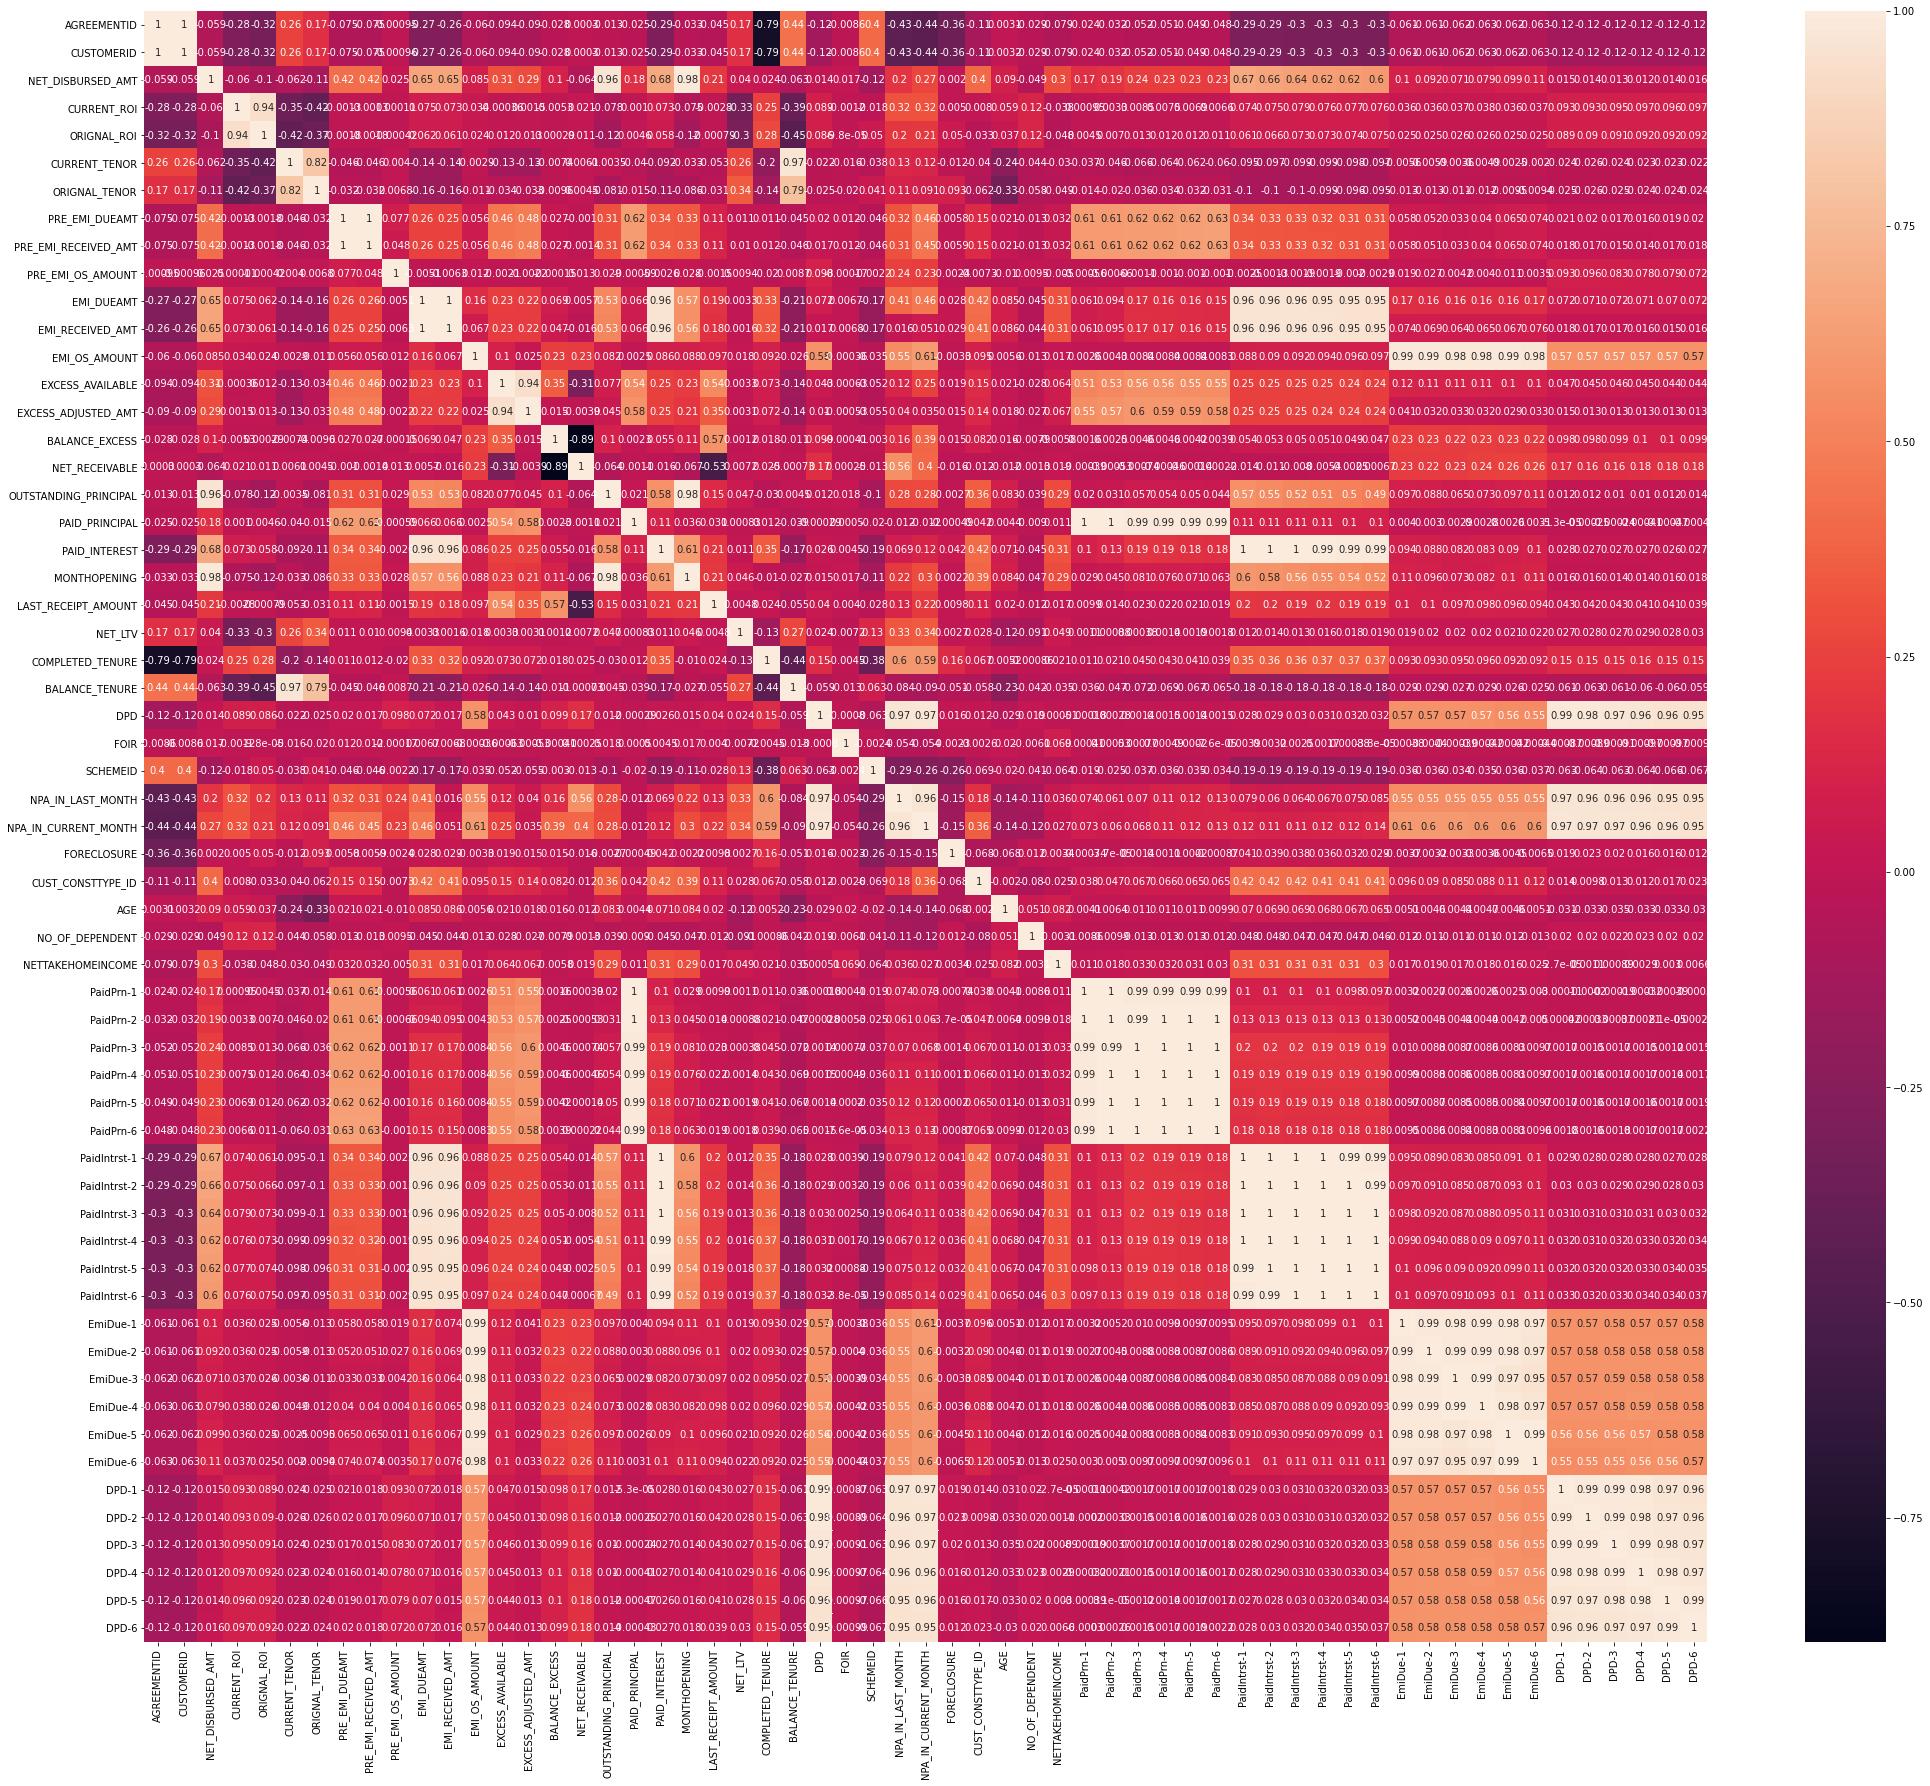

In [ ]:
plt.figure(figsize=(35,30))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Hypothesis Testing 

In [5]:
changeRoi_normal = []
changeRoi_foreclose = []

for _ in range(1000):
    m = np.mean(diff1.sample(30))
    n = np.mean(diff.sample(30))
    changeRoi_foreclose.append(m)
    changeRoi_normal.append(n)

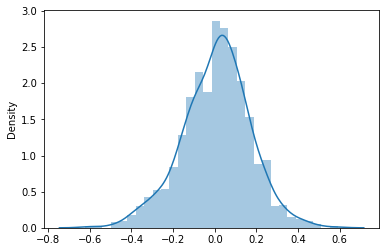

In [6]:
sns.distplot(changeRoi_foreclose)

In [7]:
sample_foreclose = changeRoi_foreclose
sample_normal = changeRoi_normal

stat, p = ttest_ind(sample_foreclose,sample_normal,equal_var=False)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('There is no difference in the rate of change in roi of loans to customers who foreclosed and the ones who didnot (fail to reject H0)')
else:
	print('The is a significant difference in the rate of change in roi of loans to customers who foreclosed and the ones who didnot (reject H0)')

Statistics=-56.892, p=0.000
The is a significant difference in the rate of change in roi of loans to customers who foreclosed and the ones who didnot (reject H0)
